In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import numpy as np


# Preparation

Some exercises need HEASOFT and ixpeobssim.





## Installing the required software

Highly recommended (not just for this tutorial): create a separate conda/venv environment

    conda create -n ixpe python=3.11 numpy scipy jupyter
    conda activate ixpe

Install all the dependencies

    pip install astropy h5py netcdf4 numba pint-pulsar jupyter ipympl
    pip install pyfftw # Currently not working on Mac M1
    pip install stingray hendrics

Install ixpeobssim: first, install HEASOFT, then

    pip install ixpeobssim

## Preparing the data

To process real-life datasets, you need to download the datasets from the archive, possibly run the L2 pipeline, and barycenter correct them with `barycorr`.


### Download
#### Method 1. Sciserver
Use the example scripts to browse the HEASARCH through TAP services:

```python
import pyvo as vo
from astropy.coordinates import SkyCoord

tap_services = vo.regsearch(servicetype='tap', keywords=['heasarc'])
heasarc_tables = tap_services[0].service.tables

pos = SkyCoord.from_name("1RXS J170849.0-4000910") # doesn't work for this
pos = SkyCoord("17h08m46.87s", "-40d08m52.44s", frame="icrs")

query="""SELECT name, cycle, prnb, obsid, time, exposure_1, ra, dec
    FROM public.ixmaster as cat
    where
    contains(point('ICRS',cat.ra,cat.dec),circle('ICRS',{},{},0.1))=1
    and
    cat.exposure_1 > 0 order by cat.time
    """.format(pos.ra.deg, pos.dec.deg)
results=tap_services[0].search(query).to_table()
results
```
and get the directory from

```python
data_path = f"/FTP/ixpe/data/obs/{results['cycle'][0]:02d}/{results['obsid'][0]}"
data_path
```

And finally copying the data path (`/FTP/ixpe/data/obs/01/01003199`) here:

    ➜  cp -r /FTP/ixpe/data/obs/01/01003199 .

#### Method 2. Browse HEASARC from the web
A typical workflow for downloading the data for a given source will include:

+ Browsing the HEASARC (through [Xamin](https://heasarc.gsfc.nasa.gov/xamin_beta/) or another tool)
![Screenshot 2024-02-21 at 16.51.20.png](attachment:015c9069-6a40-4103-9ce7-eb34ffa6814e.png)
+ Finding the wanted dataset and adding it to cart
+ Going through one of the options for download. My favorite is the wget command
![image.png](attachment:a86e52ab-d980-44c8-9f62-36a5aae99d20.png)

```
➜  wget -q -nH -r -l0 -c -N -np -R 'index*' -erobots=off --retr-symlinks --cut-dirs=5 https://heasarc.gsfc.nasa.gov/FTP/ixpe/data/obs/01//01003199/
```

Now enter the directory and.. let's start with analysis

    ➜  ls -alrt
    drwxr-xr-x  6 meo  staff   192B Feb 21 12:22 01003199/


### Pre-Processing
The IXPE archive provides level-2 files, which are usually sufficiently clean (for serious analysis it is always recommended to re-run the pipeline, but it is outside the scope of this tutorial)

For timing analysis, the most important step is familiarly called _barycentering_. It consists of the conversion from the event times from Terrestrial Time (TT; the local UT time at the spacecraft) to Barycentric Dynamical Time (TDB; the UT time at Solar System Barycenter).

The FTOOL [`barycorr`](https://heasarc.gsfc.nasa.gov/lheasoft/ftools/fhelp/barycorr.html) reads the position of the satellite from one or more orbit files in the housekeeping directory (`OBSID/hk`), another file distributed with HEASOFT that contains a set of JPL ephemerides for all objects in the Solar System, and uses them to make the necessary reference frame transformations.



`barycorr`, by default, reads the source position from the file, and uses the old JPL ephemeris DE200. For modern pulsar timing, in particular when the pulsar is fast, one needs to use very precise coordinates and ask barycorr to use a modern planetary ephemeris like DE430. Simbad is often adequate, as it strives to provide the most recent position data, often from radio or optical observations. For pulsars, the [ATNF pulsar catalog](https://www.atnf.csiro.au/research/pulsar/psrcat/) is often the best resource for precise coordinates. E.g. for 1RXS J170849.0-400910:

![image.png](attachment:6e6bc159-6d1f-40cc-a737-9233af304e0e.png)

Mind that you often need to find the name used in the catalog, which might not be the most famous name of the source. SIMBAD often gives a list of names, the PSR J<something> name is usually the one used in the ATNF catalog.


Barycorr asks for coordinates in decimal degrees, let's convert these coordinates through Astropy's coordinate conversions

In [ ]:
from astropy.coordinates import SkyCoord

coords = SkyCoord("17h08m46.87s", "-40d08m52.44s", frame="icrs")
coords.ra.deg, coords.dec.deg

(257.19529166666666, -40.1479)


IXPE often distributes more than one orbit file for a given observation. They need to get listed in a text file, and this text file has to be passed with an `@` in front when given to `barycorr`.

```
➜  ls hk/*_orb* > orbit_files
```

Putting it all together:
```
➜  barycorr event_l2/ixpe01003199_det1_evt2_v01.fits.gz ixpe01003199_det1_evt2_v02_bary.fits orbitfiles=@orbit_files ra=257.19529166666666 dec=-40.1479 refframe=ICRS ephem=JPLEPH.430
```



Do the same for all three event lists.
```
➜  barycorr event_l2/ixpe01003199_det1_evt2_v01.fits ixpe01003199_det1_evt2_v01_bary.fits orbitfiles=@orbit_files ra=257.19529166666666 dec=-40.1479 refframe=ICRS ephem=JPLEPH.430
➜  barycorr event_l2/ixpe01003199_det2_evt2_v01.fits ixpe01003199_det2_evt2_v01_bary.fits orbitfiles=@orbit_files ra=257.19529166666666 dec=-40.1479 refframe=ICRS ephem=JPLEPH.430
➜  barycorr event_l2/ixpe01003199_det3_evt2_v01.fits ixpe01003199_det3_evt2_v01_bary.fits orbitfiles=@orbit_files ra=257.19529166666666 dec=-40.1479 refframe=ICRS ephem=JPLEPH.430

```

(... I know some of you will create a script for it, even if it takes more time than just running the command three times.
That's actually what I did to print the instructions, by the way.)

### Source filtering
Use your favorite tool to create a region file and filter the source events from the background. I use `ds9` for the region and `fselect` for event selection

```
➜  for ev in ixpe01003199_det*v01_bary.fits; do fselect $ev ${ev/.fits/_filt.fits} "regfilter('ds9.reg')" clobber=yes; done
```

and we are ready to go.

One last thing: it is often useful to also extract background event lists. The way I do it is to create another region file that _excludes_ the source region, and filter the data accordingly, e.g. (notice the "-" in front of `circle`, and the large radius).

```
➜  cat ds9.reg
icrs
circle(257.1919831,-40.1475388,70.000")
```

```
➜  cat back.reg
icrs
-circle(257.1919831,-40.1475388,100.000")
```

```
➜  for ev in ixpe01003199_det*v01_bary.fits; do fselect $ev ${ev/.fits/_bkg.fits} "regfilter('back.reg')" clobber=yes; done
```


In case there is no time, preprocessed data can be found [at this address](https://drive.google.com/file/d/1VjLvewaR-ikNhjLpOk_qhK797wEgzOqX/view?usp=drive_link)

# Analysis

## Load, plot, and clean the data

In [ ]:
!ls 01003199

auxil
back.reg
ds9.reg
event_l2
hk
ixpe01003199_det1_evt2_v01_bary.fits
ixpe01003199_det1_evt2_v01_bary_bkg.fits
ixpe01003199_det1_evt2_v01_bary_filt.fits
ixpe01003199_det2_evt2_v01_bary.fits
ixpe01003199_det2_evt2_v01_bary_bkg.fits
ixpe01003199_det2_evt2_v01_bary_filt.fits
ixpe01003199_det3_evt2_v01_bary.fits
ixpe01003199_det3_evt2_v01_bary_bkg.fits
ixpe01003199_det3_evt2_v01_bary_filt.fits
orbit_files
orbitfiles.lis


In [ ]:
from stingray import EventList, AveragedPowerspectrum

events1 = EventList.read("01003199/ixpe01003199_det1_evt2_v01_bary_filt.fits", fmt="hea")
events2 = EventList.read("01003199/ixpe01003199_det2_evt2_v01_bary_filt.fits", fmt="hea")
events3 = EventList.read("01003199/ixpe01003199_det3_evt2_v01_bary_filt.fits", fmt="hea")


We can create a single event list from the three. Stingray's time series classes (`EvenList`, `Lightcurve`, etc.) have the `join` method that can be used to merge together the time series.

In [ ]:
events = events1.join(events2)
events = events.join(events3)

<AxesSubplot: xlabel='Time (s)', ylabel='counts'>

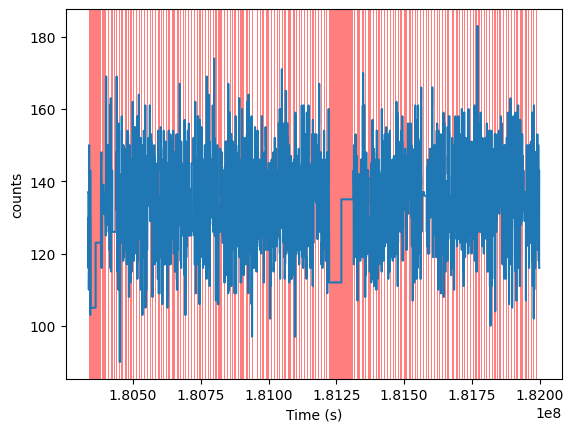

In [ ]:
lc = events.to_lc(dt=300)

# This is just to clean up the light curve from all points outside the GTIs, for plotting purposes.
lc.apply_gtis(inplace=True)
lc.plot()

Let us take a look at the background as well

<AxesSubplot: xlabel='Time (s)', ylabel='counts'>

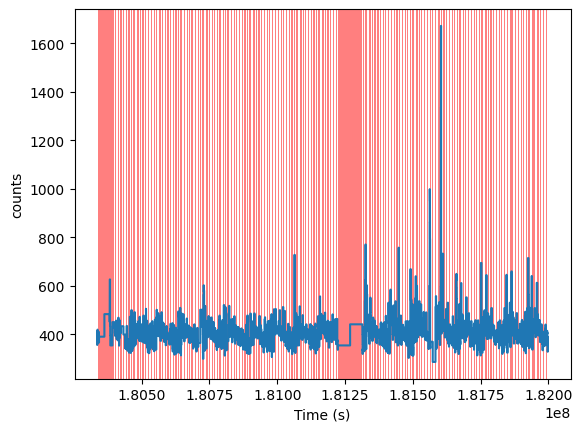

In [ ]:
events1_bkg = EventList.read("01003199/ixpe01003199_det1_evt2_v01_bary_bkg.fits", fmt="hea")
events2_bkg = EventList.read("01003199/ixpe01003199_det2_evt2_v01_bary_bkg.fits", fmt="hea")
events3_bkg = EventList.read("01003199/ixpe01003199_det3_evt2_v01_bary_bkg.fits", fmt="hea")

events_bkg = events1_bkg.join(events2_bkg)
events_bkg = events_bkg.join(events3_bkg)
lc_bkg = events_bkg.to_lc(dt=300)

# This is just to clean up the light curve from all points outside the GTIs, for plotting purposes.
lc_bkg.apply_gtis(inplace=True)
lc_bkg.plot()

The background shows spikes in the same time frames, which makes the magnetar burst hypothesis a lot less likely.

It is convenient to eliminate these times from the original data as well, in order to get a cleaner dataset.

<AxesSubplot: xlabel='Time (s)', ylabel='counts'>

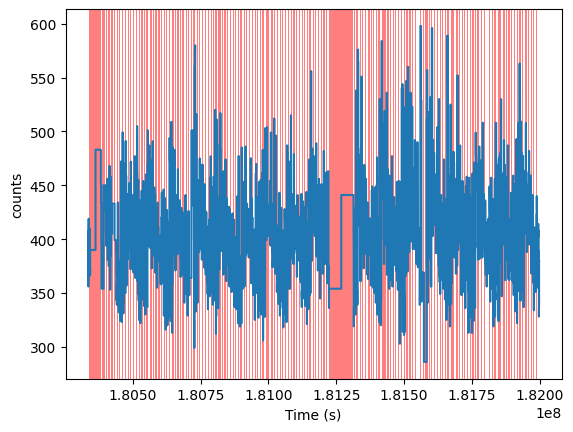

In [ ]:
from stingray.gti import cross_gtis, create_gti_from_condition
good = lc_bkg.counts < 600
new_gti = create_gti_from_condition(lc_bkg.time, good)

events_bkg.gti = cross_gtis([new_gti, events_bkg.gti])
lc_bkg = events_bkg.to_lc(dt=300)
lc_bkg.apply_gtis()
lc_bkg.plot()

Ok, the new GTIs eliminate most of the pernicious background flares. Let us apply them to the event lists as well

<AxesSubplot: xlabel='Time (s)', ylabel='counts'>

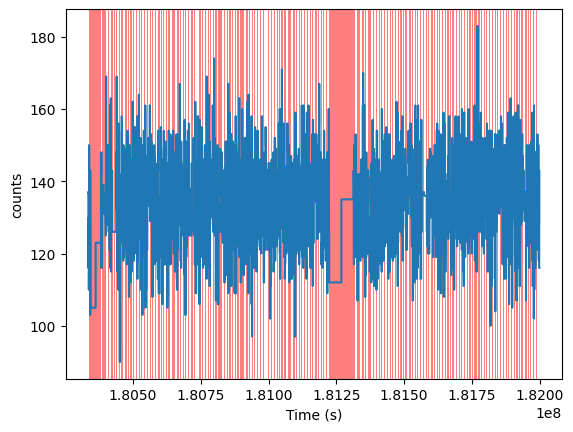

In [ ]:
events.gti = cross_gtis([new_gti, events.gti])
lc = events.to_lc(300)
lc.apply_gtis()
lc.plot()

In [ ]:
events.write("filtered_events.hdf5")

## Periodogram

We will now look at the periodogram, to see if we see any hint of source variability, both periodic or aperiodic.

In [ ]:
pds = AveragedPowerspectrum.from_events(events, dt=0.0005, segment_size=256, norm="leahy")


2910it [00:39, 73.57it/s]


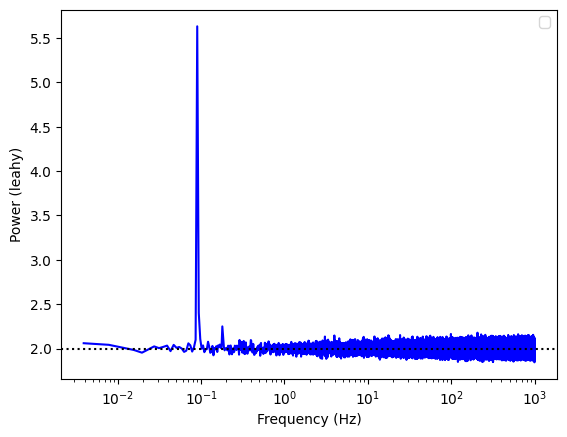

In [ ]:
pds_reb = pds.rebin_log(0.03)
# pds_reb.plot()
pds.plot()
plt.semilogx();
plt.axhline(2, ls=":", color="k")

A pulsar!

Mind: it will _not_ always be so simple ;)

Let's zoom in and find an approximate pulse period

(0.07, 0.11)

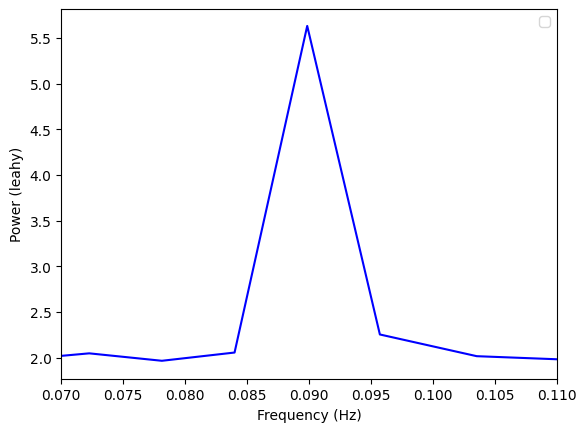

In [ ]:
pds_reb.plot()
plt.xlim([0.07, 0.11])

## Accelerated Pulsar search

We will now move to a shell and use HENDRICS. Note that all we have done at the moment could be done from the command line, and what we are doing from now on could be done from the HENDRICS API.

```
➜  HENzsearch --fmin 0.085 --fmax 0.095 --fast -N 3 filtered_events.hdf5
/Users/meo/opt/anaconda3/envs/ixpe/lib/python3.10/site-packages/hendrics/io.py:38: UserWarning: Warning! NetCDF is not available. Using pickle format.
  warnings.warn(msg)
/Users/meo/opt/anaconda3/envs/ixpe/lib/python3.10/site-packages/hendrics/fold.py:38: UserWarning: PINT is not installed. Some pulsar functionality will not be available
  warnings.warn(
  0%|                                                                                                                                                | 0/2080 [00:00<?, ?it/s]OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2080/2080 [03:00<00:00, 11.50it/s]
Best candidate(s):
       mjd                 f             fdot   fddot  power   Pulsed amplitude (%)
----------------- ------------------- --------- ----- -------- --------------------
59850.84174943358 0.09079581655063641 -2.51e-13     0 15006.59   28.1736 ± 0.112248
59850.84174943358 0.09079581655063641  2.51e-13     0 13353.50   26.5766 ± 0.112529
59850.84174943358 0.09079581655063641 -7.54e-13     0 13268.33   26.4917 ± 0.112545
59850.84174943358 0.09079560746966174 -2.51e-13     0 12842.51   26.0631 ± 0.112627
59850.84174943358 0.09079560746966174  2.51e-13     0 12367.58   25.5767 ± 0.112723
['filtered_events_Z23_0.085-0.095Hz_fast.nc']

```

We can plot the results with

```
➜  HENplot filtered_events_Z23_0.085-0.095Hz_fast.nc
```

And the tool itself will suggest to use `HENphaseogram` to go on.


## Interactive refinement of the solution: HENPhaseogram
Let's use `HENphaseogram` as suggested by HENzsearch
```
HENphaseogram -f 0.09079581655063641 --fdot -2.513604103145406e-13 filtered_events.hdf5 -n 128 --ntimes 750 --norm meansub --pepoch 59850.84174943358
```

Change the values of the `-n` and `--ntimes` options to get a visible track in the plot.
![image.png](attachment:dcb9aa30-ed03-40ed-96b9-c793eba8ea86.png)

If we have the correct pulse solution, the pulse phase has to trace a vertical pattern in this plot.
The tool can be used interactively to adjust the solution, by moving three sliders indicating the pulse frequency and the first two derivatives.

![Screenshot 2024-02-21 at 22.55.22.png](attachment:cf9385e5-7167-4521-941d-2bc0cfe80c5e.png)

By pressing the TOA button, the user can get an approximate timing ephemeris, and a set of pulse times of arrival, that can be fit with Tempo2/PINT. For this, it is important to fix `--ntimes` to a value that allows sufficient statistics for a good TOA, but a sufficient number of TOAs to be used for fitting.


## Refine the solution further, with PINT
At this point, the user can use the `pintk` tool to fit the TOAs and get a precise timing solution.

```
➜  pintk filtered_events.par filtered_events.tim
```

And use the interface to get the best fit:

+ Select the models and parameters to fit
+ Press "Fit"
+ Press the "Write par" button to write a new parameter file (or press "o" while overing on the plot to print the current best fit in the terminal)

You can press "h" while hovering on the plot to get the help printed on the command line

![Screenshot 2024-06-11 at 08.38.09.png](attachment:c03fea1a-ed05-4f3c-af69-354fc25f1639.png)


# Bonus: Polarimetric analysis

The data we are analyzing are from the IXPE satellite. We can make a polarimetric analysis (but needs ixpeobssim installed).

What we are going to calculate here is the change of polarization during the pulse. We do it in four steps:

+ Cleaning up the data
+ Calculating the phase of each photon
+ Splitting the list of photons in groups, classified by phase range
+ Calculating the average polarization of the photons in each phase group

In [ ]:
import ixpeobssim.core.pipeline as pipeline
from ixpeobssim.binning.base import xEventBinningBase
from ixpeobssim.binning.misc import xBinnedPulseProfile
from ixpeobssim.binning.polarization import xBinnedPolarizationCube
from ixpeobssim.utils.misc import pairwise_enum
from ixpeobssim.utils.matplotlib_ import plt, setup_gca, last_line_color
from ixpeobssim.utils.fmtaxis import fmtaxis, label

PHASE_BINNING = np.linspace(0., 1., 10)
ENERGY_BINNING = np.array([2., 8.])
USE_MC = True


>>> PyXSPEC is not installed, you will no be able to use it.
>>> No module named 'mido'
>>> mido is a library to manipulate MIDI files.
>>> See https://mido.readthedocs.io/en/latest/ for more details.
>>> Type `pip install --user mido` to install it


In [ ]:
!cat filtered_events.par

PEPOCH         59850.84174943358
PSRJ           None
F0             0.09079573105974899
F1             -1.4215827650018608e-13
F2             0.0
# PEPOCH(MET)  181167057.96706164
START         59841.21443316426
FINISH        59860.46443316426



Copy the relevant parameters: the PEPOCH in MET, F0 and F1 in particular

In [ ]:
input_model = {'met0': 181167057.96706164, 'nu0': 0.09079575777565131, 'nudot0': -1.5500558636069862e-13}

Run XPselect to filter the input files

In [ ]:
input_files = glob.glob("01003199/ixpe01003199_det*_evt2_v01_bary.fits")

file_list = pipeline.xpselect(*input_files, regfile="01003199/ds9.reg")


>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary.fits...



    Welcome to ixpeobssim 31.0.1 (built on Fri, 08 Mar 2024 08:38:15 +0100).

    Copyright (C) 2015--2023, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      66   ()      
  1  EVENTS        1 BinTableHDU    252   515004R x 10C   [J, D, 16X, 16X, J, E, E, E, D, D]   
  2  GTI           1 BinTableHDU     63   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary.fits', '01003199/ixpe01003199_det2_evt2_v01_bary.fits', '01003199/ixpe01003199_det1_evt2_v01_bary.fits'], 'suffix': None, 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': None, 'phasemax': None, 'phaseinvert': False, 'emin': None, 'emax': None, 'einvert': False, 'ra': None, 'dec': None, 'rad': None, 'innerrad': None, 'regfile': '01003199/ds

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    253   120029R x 10C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      66   ()      
  1  EVENTS        1 BinTableHDU    252   547932R x 10C   [J, D, 16X, 16X, J, E, E, E, D, D]   
  2  GTI           1 BinTableHDU     63   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary.fits', '01003199/ixpe01003199_det2_evt2_v01_bary.fits', '01003199/ixpe01003199_det1_evt2_v01_bary.fits'], 'suffix': None, 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': None, 'phasemax': None, 'phaseinvert': False, 'emin': None, 'emax': None, 'einvert': False, 'ra': N

Filename: 01003199/ixpe01003199_det2_evt2_v01_bary.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    253   124758R x 10C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D']   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      66   ()      
  1  EVENTS        1 BinTableHDU    252   548763R x 10C   [J, D, 16X, 16X, J, E, E, E, D, D]   
  2  GTI           1 BinTableHDU     63   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary.fits', '01003199/ixpe01003199_det2_evt2_v01_bary.fits', '01003199/ixpe01003199_det1_evt2_v01_bary.fits'], 'suffix': None, 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': None, 'phasemax': None, 'phaseinvert': False, 'emin': None, 'emax': None, 'einvert': False, 'ra': N

Filename: 01003199/ixpe01003199_det1_evt2_v01_bary.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    253   133331R x 10C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Done.
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary.fits...


Run Xpphase to calculate the pulse phase of each photon, given the input model

In [ ]:
phased_files = pipeline.xpphase(*file_list, suffix='folded', **input_model)

phase_selected = []
for i, (min_, max_) in pairwise_enum(PHASE_BINNING):
    outlist = pipeline.xpselect(*phased_files, phasemin=min_, phasemax=max_,
                      suffix=pipeline.suffix('phase', i))
    phase_selected.extend(outlist)
phase_selected

>>> Opening "01003199/ixpe01003199_det3_evt2_v01_bary_select.fits"...
>>> Calculating pulsar phase...
>>> Creating phase column...
>>> Writing to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits...



    Welcome to ixpeobssim 31.0.1 (built on Fri, 08 Mar 2024 08:38:15 +0100).

    Copyright (C) 2015--2023, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   120029R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Opening "01003199/ixpe01003199_det2_evt2_v01_bary_select.fits"...
>>> Calculating pulsar phase...
>>> Creating phase column...
>>> Writing to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   124758R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Opening "01003199/ixpe01003199_det1_evt2_v01_bary_select.fits"...
>>> Calculating pulsar phase...
>>> Creating phase column...
>>> Writing to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   133331R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Done!
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits...



    Welcome to ixpeobssim 31.0.1 (built on Fri, 08 Mar 2024 08:38:15 +0100).

    Copyright (C) 2015--2023, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   120029R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0000', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.0, 'phasemax': 0.1111111111111111, 'phaseinvert': False, 'emin': None, 'emax': None, 'einvert': False, 

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   11472R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   124758R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0000', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.0, 'phasemax': 0.

Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   11978R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   133331R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0000', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.0, 'phasemax': 0.

Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   12653R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Done.
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits...
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits...



    Welcome to ixpeobssim 31.0.1 (built on Fri, 08 Mar 2024 08:38:15 +0100).

    Copyright (C) 2015--2023, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   120029R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0001', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.1111111111111111, 'phasemax': 0.2222222222222222, 'phaseinvert': False, 'emin': None, 'emax': None, 'ei

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10531R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   124758R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0001', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.1111111111111111,

Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10736R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   133331R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0001', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.1111111111111111,

Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11721R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Done.
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits...
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits...



    Welcome to ixpeobssim 31.0.1 (built on Fri, 08 Mar 2024 08:38:15 +0100).

    Copyright (C) 2015--2023, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   120029R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0002', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.2222222222222222, 'phasemax': 0.3333333333333333, 'phaseinvert': False, 'emin': None, 'emax': None, 'ei

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10841R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   124758R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0002', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.2222222222222222,

Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11252R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   133331R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0002', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.2222222222222222,

Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12051R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Done.
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits...
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits...



    Welcome to ixpeobssim 31.0.1 (built on Fri, 08 Mar 2024 08:38:15 +0100).

    Copyright (C) 2015--2023, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   120029R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0003', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.3333333333333333, 'phasemax': 0.4444444444444444, 'phaseinvert': False, 'emin': None, 'emax': None, 'ei

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11002R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   124758R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0003', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.3333333333333333,

Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11371R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   133331R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0003', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.3333333333333333,

Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12346R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Done.
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits...
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits...



    Welcome to ixpeobssim 31.0.1 (built on Fri, 08 Mar 2024 08:38:15 +0100).

    Copyright (C) 2015--2023, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   120029R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0004', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.4444444444444444, 'phasemax': 0.5555555555555556, 'phaseinvert': False, 'emin': None, 'emax': None, 'ei

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11620R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   124758R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0004', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.4444444444444444,

Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12132R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   133331R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0004', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.4444444444444444,

Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12869R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Done.
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits...
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits...



    Welcome to ixpeobssim 31.0.1 (built on Fri, 08 Mar 2024 08:38:15 +0100).

    Copyright (C) 2015--2023, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   120029R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0005', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.5555555555555556, 'phasemax': 0.6666666666666666, 'phaseinvert': False, 'emin': None, 'emax': None, 'ei

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   14688R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   124758R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0005', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.5555555555555556,

Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   15096R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   133331R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0005', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.5555555555555556,

Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   16266R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Done.
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits...
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits...



    Welcome to ixpeobssim 31.0.1 (built on Fri, 08 Mar 2024 08:38:15 +0100).

    Copyright (C) 2015--2023, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   120029R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0006', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.6666666666666666, 'phasemax': 0.7777777777777777, 'phaseinvert': False, 'emin': None, 'emax': None, 'ei

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   16363R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   124758R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0006', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.6666666666666666,

Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   17194R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   133331R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0006', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.6666666666666666,

Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18443R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Done.
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits...
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits...



    Welcome to ixpeobssim 31.0.1 (built on Fri, 08 Mar 2024 08:38:15 +0100).

    Copyright (C) 2015--2023, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   120029R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0007', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.7777777777777777, 'phasemax': 0.8888888888888888, 'phaseinvert': False, 'emin': None, 'emax': None, 'ei

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18176R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   124758R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0007', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.7777777777777777,

Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18555R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   133331R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0007', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.7777777777777777,

Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   19987R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Done.
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits...
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits...



    Welcome to ixpeobssim 31.0.1 (built on Fri, 08 Mar 2024 08:38:15 +0100).

    Copyright (C) 2015--2023, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   120029R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0008', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.8888888888888888, 'phasemax': 1.0, 'phaseinvert': False, 'emin': None, 'emax': None, 'einvert': False, 

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   15336R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   124758R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0008', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.8888888888888888,

Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   16444R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   133331R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits...
>>> Running event selection with kwargs {'filelist': ['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits', '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits'], 'suffix': 'phase0008', 'tmin': None, 'tmax': None, 'tinvert': False, 'phasemin': 0.8888888888888888,

Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   16995R x 11C   ['J', 'D', '16X', '16X', 'J', 'E', 'E', 'E', 'D', 'D', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Done.
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits...


['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000.fits',
 '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits',
 '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits',
 '01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits',
 '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits',
 '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits',
 '01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits',
 '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits',
 '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits',
 '01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits',
 '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits',
 '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits',
 '01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits',
 '01003199/ixpe01003199_det2_evt2_v01_

Run Xpbin to get the polarimetric spectra for each phase bin

In [ ]:
pipeline.xpbin(*phased_files, algorithm='PP')

binned = []
for i, (min_, max_) in pairwise_enum(PHASE_BINNING):
    outlist = pipeline.xpbin(*phase_selected, algorithm='PCUBE', ebinalg='LIST',
                   ebinning=ENERGY_BINNING, irfname="ixpe:obssim:v10")
    binned.extend(outlist)
binned

>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits...



    Welcome to ixpeobssim 31.0.1 (built on Fri, 08 Mar 2024 08:38:15 +0100).

    Copyright (C) 2015--2023, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   120029R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> MONTE_CARLO extension not available, cannot retrieve simulation IRF name
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_pp.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     38   ()      
  1  RATE          1 xBinTableHDUPP     41   50R x 4C   ['D', 'D', 'J', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Writing PP binned data to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_pp.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   124758R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> MONTE_CARLO extension not available, cannot retrieve simulation IRF name
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_pp.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     38   ()      
  1  RATE          1 xBinTableHDUPP     41   50R x 4C   ['D', 'D', 'J', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Writing PP binned data to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_pp.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1  EVENTS        1 BinTableHDU    255   133331R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> MONTE_CARLO extension not available, cannot retrieve simulation IRF name
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_pp.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     38   ()      
  1  RATE          1 xBinTableHDUPP     41   50R x 4C   ['D', 'D', 'J', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Writing PP binned data to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_pp.fits...
>>> Done.
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded.fits...
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000.fits...



    Welcome to ixpeobssim 31.0.1 (built on Fri, 08 Mar 2024 08:38:15 +0100).

    Copyright (C) 2015--2023, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   11472R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Energy binning: [2. 8.]
>>> Reading (in memory) /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d3_obssim_mfact_v010.fits...
>>> Reading (in memory) /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d3_obssim_v010.arf...
>>> Performing un-weighted analysis...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   11978R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000.fits...
>>> Energy binning: [2. 8.]
>>> Reading (in memory) /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d2_obssim_mfact_v010.fits...
>>> Reading (in memory) /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d2_obssim_v010.arf...
>>> Performing un-weighte

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   12653R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits...
>>> Energy binning: [2. 8.]
>>> Reading (in memory) /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d1_obssim_mfact_v010.fits...
>>> Reading (in memory) /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d1_obssim_v010.arf...
>>> Performing un-weighte

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10531R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d3_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d3_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10736R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d2_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d2_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11721R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d1_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d1_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10841R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d3_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d3_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11252R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d2_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d2_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12051R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d1_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d1_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11002R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d3_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d3_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11371R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d2_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d2_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12346R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d1_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d1_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11620R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d3_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d3_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12132R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d2_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d2_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12869R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d1_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d1_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   14688R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d3_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d3_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   15096R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d2_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d2_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   16266R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d1_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d1_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   16363R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d3_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d3_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   17194R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d2_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d2_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18443R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d1_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d1_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18176R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d3_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d3_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18555R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d2_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d2_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   19987R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d1_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d1_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   15336R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d3_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d3_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   16444R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d2_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d2_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Done.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   16995R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits...
>>> Energy binning: [2. 8.]
>>> Using cached xModulationFactor object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/modfact/ixpe_d1_obssim_mfact_v010.fits...
>>> Using cached xEffectiveArea object at /Users/meo/.local/lib/python3.11/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d1_obssi

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 xPrimaryHDU     63   ()      
  1  POLARIZATION    1 xBinTableHDUPCUBE     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Writing PCUBE binned data to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Done.
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits...
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000.fits...



    Welcome to ixpeobssim 31.0.1 (built on Fri, 08 Mar 2024 08:38:15 +0100).

    Copyright (C) 2015--2023, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   11472R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   11978R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   12653R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10531R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10736R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11721R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10841R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11252R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12051R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11002R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11371R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12346R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11620R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12132R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12869R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   14688R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   15096R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   16266R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   16363R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   17194R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18443R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18176R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18555R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   19987R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   15336R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   16444R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   16995R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits...
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bar


    Welcome to ixpeobssim 31.0.1 (built on Fri, 08 Mar 2024 08:38:15 +0100).

    Copyright (C) 2015--2023, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   11472R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   11978R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   12653R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10531R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10736R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11721R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10841R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11252R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12051R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11002R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11371R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12346R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11620R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12132R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12869R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   14688R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   15096R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   16266R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   16363R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   17194R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18443R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18176R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18555R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   19987R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   15336R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   16444R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   16995R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits...
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bar


    Welcome to ixpeobssim 31.0.1 (built on Fri, 08 Mar 2024 08:38:15 +0100).

    Copyright (C) 2015--2023, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   11472R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   11978R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   12653R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10531R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10736R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11721R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10841R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11252R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12051R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11002R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11371R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12346R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11620R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12132R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12869R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   14688R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   15096R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   16266R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   16363R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   17194R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18443R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18176R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18555R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   19987R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   15336R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   16444R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   16995R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits...



    Welcome to ixpeobssim 31.0.1 (built on Fri, 08 Mar 2024 08:38:15 +0100).

    Copyright (C) 2015--2023, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.



>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   11472R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   11978R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   12653R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10531R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10736R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11721R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10841R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11252R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12051R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11002R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11371R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12346R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11620R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12132R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12869R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   14688R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   15096R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   16266R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   16363R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   17194R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18443R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18176R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18555R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   19987R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   15336R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   16444R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   16995R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits...
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bar


    Welcome to ixpeobssim 31.0.1 (built on Fri, 08 Mar 2024 08:38:15 +0100).

    Copyright (C) 2015--2023, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   11472R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   11978R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   12653R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10531R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10736R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11721R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10841R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11252R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12051R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11002R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11371R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12346R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11620R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12132R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12869R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   14688R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   15096R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   16266R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   16363R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   17194R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18443R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18176R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18555R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   19987R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   15336R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   16444R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   16995R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits...
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bar


    Welcome to ixpeobssim 31.0.1 (built on Fri, 08 Mar 2024 08:38:15 +0100).

    Copyright (C) 2015--2023, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   11472R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   11978R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   12653R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10531R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10736R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11721R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10841R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11252R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12051R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11002R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11371R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12346R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11620R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12132R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12869R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   14688R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   15096R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   16266R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   16363R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   17194R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18443R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18176R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18555R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   19987R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   15336R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   16444R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   16995R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits...
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bar


    Welcome to ixpeobssim 31.0.1 (built on Fri, 08 Mar 2024 08:38:15 +0100).

    Copyright (C) 2015--2023, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   11472R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   11978R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   12653R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10531R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10736R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11721R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10841R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11252R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12051R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11002R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11371R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12346R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11620R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12132R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12869R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   14688R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   15096R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   16266R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   16363R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   17194R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18443R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18176R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18555R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   19987R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   15336R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   16444R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   16995R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits...
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bar


    Welcome to ixpeobssim 31.0.1 (built on Fri, 08 Mar 2024 08:38:15 +0100).

    Copyright (C) 2015--2023, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   11472R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   11978R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   12653R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10531R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10736R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11721R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   10841R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11252R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12051R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11002R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11371R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12346R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   11620R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12132R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   12869R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   14688R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   15096R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   16266R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   16363R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   17194R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18443R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18176R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   18555R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      87   ()      
  1  EVENTS        1 BinTableHDU    255   19987R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   15336R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007.fits...
>>> Output file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   16444R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   757R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008.fits...
>>> Output file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Opening input event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits...


Filename: 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   ()      
  1  EVENTS        1 BinTableHDU    255   16995R x 11C   [J, D, 16X, 16X, J, E, E, E, D, D, E]   
  2  GTI           1 BinTableHDU     64   761R x 2C   [D, D]   


>>> Reading WCS information from the EVENTS HDU...
>>> WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 257.19529 -40.1479 
CRPIX : 299.0 299.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00072222 0.00072222 
NAXIS : 600  600
>>> Loading data from the MONTE_CARLO extension...
>>> Event file comes without a MONTE_CARLO extension.
>>> Re-building the ROI table...
>>> Input file has no ROITABLE extension, cannot rebuild ROI table.
>>> Setting outfile to 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008_pcube.fits...
>>> Closing event file 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008.fits...
>>> Output file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008_pcube.fits already exists.
>>> Remove it or set "overwrite = True" to overwite it.
>>> Closing event file 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008.fits...


['01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000_pcube.fits',
 '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000_pcube.fits',
 '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000_pcube.fits',
 '01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001_pcube.fits',
 '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001_pcube.fits',
 '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001_pcube.fits',
 '01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002_pcube.fits',
 '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002_pcube.fits',
 '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002_pcube.fits',
 '01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003_pcube.fits',
 '01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003_pcube.fits',
 '01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003_pcube.fits',
 '01003199/ixpe01003199_det3_evt2_v01_ba

In [ ]:
phase = np.linspace(0., 1., 100)
phase_bins = xEventBinningBase.bin_centers(PHASE_BINNING)
shape = (len(ENERGY_BINNING) - 1, len(PHASE_BINNING) - 1)
pol_deg = np.zeros(shape)
pol_deg_err = np.zeros(shape)
pol_ang = np.zeros(shape)
pol_ang_err = np.zeros(shape)
emean = np.zeros(shape)

print(shape)

for i, (min_, max_) in pairwise_enum(PHASE_BINNING):
    pcube = xBinnedPolarizationCube.from_file_list(glob.glob("01003199/*folded*" + pipeline.suffix('phase', i) + "*pcube*"))
    print(pcube)
    pol_deg[:,i] = pcube.PD
    pol_deg_err[:,i] = pcube.PD_ERR
    pol_ang[:,i] = pcube.PA
    pol_ang_err[:,i] = pcube.PA_ERR
    emean[:,i] = pcube.E_MEAN


(1, 9)


>>> Reading (in memory) 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0000_pcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   ['D', 'D']   


>>> Reading (in memory) 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0000_pcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   ['D', 'D']   


>>> Reading (in memory) 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0000_pcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   ['D', 'D']   


>>> Reading (in memory) 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0001_pcube.fits...


xBinnedPolarizationCube content:
Quantity     2.00--8.00 keV   
-------- ---------------------
  E_MEAN    3.6292127902715836
  COUNTS               21602.0
      MU   0.31742316705690005
      W2     150.7541046142578
   N_EFF      10456.1005859375
  FRAC_W    0.4840339128755439
  MDP_99    0.1321702710760191
       I    1255.5079345703125
   I_ERR    12.278196334838867
       Q   -245.31369018554688
     ...                   ...
      UN  -0.35678941011428833
  UN_ERR   0.04343045830519874
 QUN_COV -6.66721597766525e-06
      PD   0.40678733587265015
  PD_ERR  0.043405691834685185
      PA    -59.35330569865696
  PA_ERR    3.0696561746989572
 P_VALUE 9.322591416325978e-20
  CONFID                   1.0
  SIGNIF     9.361528267671195
Length = 25 rows
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C   ['E', 'E', 'E', 'J',

>>> Reading (in memory) 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0001_pcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   ['D', 'D']   


>>> Reading (in memory) 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0001_pcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   ['D', 'D']   


>>> Reading (in memory) 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0002_pcube.fits...


xBinnedPolarizationCube content:
Quantity      2.00--8.00 keV    
-------- -----------------------
  E_MEAN        3.74100889363716
  COUNTS                 20020.0
      MU      0.3242785727282673
      W2      162.05795288085938
   N_EFF          8953.333984375
  FRAC_W       0.447219479739011
  MDP_99     0.13981270724674452
       I         1204.5576171875
   I_ERR      12.730198860168457
       Q      -159.6666259765625
     ...                     ...
      UN    -0.41650766134262085
  UN_ERR    0.045879070766784845
 QUN_COV -6.1663016996583505e-06
      PD      0.4370911419391632
  PD_ERR     0.04587672691252313
      PA     -53.826743509105775
  PA_ERR      3.0220757729208483
 P_VALUE   2.021466318153383e-20
  CONFID                     1.0
  SIGNIF       9.523405228983073
Length = 25 rows
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTab

>>> Reading (in memory) 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0002_pcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   ['D', 'D']   


>>> Reading (in memory) 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0002_pcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   ['D', 'D']   
xBinnedPolarizationCube content:
Quantity     2.00--8.00 keV   
-------- ---------------------
  E_MEAN    3.6193994378969494
  COUNTS               20374.0
      MU   0.31522493381609956
      W2    150.94577026367188
   N_EFF        9100.912109375
  FRAC_W   0.44669245653160894
  MDP_99    0.1426573869959359
       I        1172.068359375
   I_ERR    12.285999298095703
       Q   -247.30340576171875
     ...                   ...
      UN  -0.33245307207107544
  UN_ERR   0.04689820959317155
 QUN_COV -7.70765985093739e-06
      PD   0.39375749230384827
  PD_ERR   0.046

>>> Reading (in memory) 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0003_pcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   ['D', 'D']   


>>> Reading (in memory) 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0003_pcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   ['D', 'D']   


>>> Reading (in memory) 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0003_pcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   ['D', 'D']   


>>> Reading (in memory) 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0004_pcube.fits...


xBinnedPolarizationCube content:
Quantity     2.00--8.00 keV    
-------- ----------------------
  E_MEAN     3.3953060214453186
  COUNTS                19602.0
      MU    0.29905159920113034
      W2     114.74447631835938
   N_EFF          9636.14453125
  FRAC_W     0.4915898648734823
  MDP_99    0.14613676441374457
       I       1051.52001953125
   I_ERR     10.711884498596191
       Q     -278.7890930175781
     ...                    ...
      UN   -0.34432128071784973
  UN_ERR    0.04804663400244772
 QUN_COV  -9.47368114191036e-06
      PD    0.43456971645355225
  PD_ERR    0.04799348770180955
      PA    -63.798249376528695
  PA_ERR     3.1772909972825043
 P_VALUE 1.7784673001833553e-18
  CONFID                    1.0
  SIGNIF      9.041098925265116
Length = 25 rows
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C

>>> Reading (in memory) 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0004_pcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   ['D', 'D']   


>>> Reading (in memory) 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0004_pcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   ['D', 'D']   


>>> Reading (in memory) 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0005_pcube.fits...


xBinnedPolarizationCube content:
Quantity     2.00--8.00 keV    
-------- ----------------------
  E_MEAN     3.4484823186092233
  COUNTS                20912.0
      MU    0.30239935457489336
      W2     129.24002075195312
   N_EFF         9995.498046875
  FRAC_W     0.4779790573295237
  MDP_99    0.14189731700968475
       I     1136.5819091796875
   I_ERR     11.368377685546875
       Q    -241.37362670898438
     ...                    ...
      UN    -0.3131093680858612
  UN_ERR    0.04667199516655366
 QUN_COV -6.652436023722232e-06
      PD     0.3783353567123413
  PD_ERR    0.04664415460963755
      PA    -62.073640271478816
  PA_ERR      3.543551420238216
 P_VALUE 5.5187608333206875e-15
  CONFID     0.9999999999999944
  SIGNIF      7.725949887459127
Length = 25 rows
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C

>>> Reading (in memory) 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0005_pcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   ['D', 'D']   


>>> Reading (in memory) 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0005_pcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   ['D', 'D']   


>>> Reading (in memory) 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0006_pcube.fits...


xBinnedPolarizationCube content:
Quantity      2.00--8.00 keV    
-------- -----------------------
  E_MEAN      3.3218995537865523
  COUNTS                 27364.0
      MU     0.29556262057646326
      W2      138.38470458984375
   N_EFF         14913.748046875
  FRAC_W      0.5450134500392851
  MDP_99     0.11885415237386625
       I       1436.605224609375
   I_ERR      11.763702392578125
       Q      -287.7083435058594
     ...                     ...
      UN    -0.26070284843444824
  UN_ERR     0.03912249102158869
 QUN_COV -3.5008540573341955e-06
      PD     0.32874593138694763
  PD_ERR    0.039101715608279214
      PA      -63.76557375153935
  PA_ERR      3.4155099224983236
 P_VALUE   4.721872020580899e-16
  CONFID      0.9999999999999996
  SIGNIF       8.041399959096541
Length = 25 rows
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTab

>>> Reading (in memory) 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0006_pcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   ['D', 'D']   


>>> Reading (in memory) 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0006_pcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   ['D', 'D']   


>>> Reading (in memory) 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0007_pcube.fits...


xBinnedPolarizationCube content:
Quantity     2.00--8.00 keV    
-------- ----------------------
  E_MEAN      3.304964731782321
  COUNTS                31193.0
      MU    0.29526356595448144
      W2     152.27145385742188
   N_EFF        17557.201171875
  FRAC_W     0.5628570888300259
  MDP_99    0.10965282110686188
       I      1635.072021484375
   I_ERR     12.339832305908203
       Q    -222.65301513671875
     ...                    ...
      UN    -0.2264995276927948
  UN_ERR     0.0361069957397469
 QUN_COV -1.756724771309574e-06
      PD    0.26428237557411194
  PD_ERR     0.0361034106202787
      PA     -60.50730030987647
  PA_ERR      3.919537295235074
 P_VALUE  2.349506919702409e-12
  CONFID     0.9999999999976505
  SIGNIF      6.914386998797693
Length = 25 rows
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C

>>> Reading (in memory) 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0007_pcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   ['D', 'D']   


>>> Reading (in memory) 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0007_pcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   ['D', 'D']   


>>> Reading (in memory) 01003199/ixpe01003199_det3_evt2_v01_bary_select_folded_phase0008_pcube.fits...


xBinnedPolarizationCube content:
Quantity     2.00--8.00 keV   
-------- ---------------------
  E_MEAN    3.3695625893667094
  COUNTS               33622.0
      MU   0.29869750885007523
      W2    183.62664794921875
   N_EFF         17496.4921875
  FRAC_W     0.520388203780263
  MDP_99   0.10858008656325303
       I    1792.4346923828125
   I_ERR    13.550890922546387
       Q   -219.04507446289062
     ...                   ...
      UN  -0.06884730607271194
  UN_ERR   0.03579002337736812
 QUN_COV  -4.8086826553742e-07
      PD    0.1402643769979477
  PD_ERR  0.035788081867574886
      PA    -75.30211159933856
  PA_ERR     7.312642412533774
 P_VALUE 0.0004609174590262741
  CONFID    0.9995390825409737
  SIGNIF    3.3133562143729782
Length = 25 rows
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C   ['E', 'E', 'E', 'J',

>>> Reading (in memory) 01003199/ixpe01003199_det1_evt2_v01_bary_select_folded_phase0008_pcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   761R x 2C   ['D', 'D']   


>>> Reading (in memory) 01003199/ixpe01003199_det2_evt2_v01_bary_select_folded_phase0008_pcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  POLARIZATION    1 BinTableHDU     88   1R x 27C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     64   757R x 2C   ['D', 'D']   
xBinnedPolarizationCube content:
Quantity      2.00--8.00 keV    
-------- -----------------------
  E_MEAN      3.4518277105671684
  COUNTS                 28666.0
      MU     0.30362798897957666
      W2       172.5109405517578
   N_EFF           14165.7578125
  FRAC_W      0.4941658345252215
  MDP_99     0.11871226401717037
       I       1563.249267578125
   I_ERR      13.134342193603516
       Q     -223.99200439453125
     ...                     ...
      UN    -0.15053105354309082
  UN_ERR    0.039113470033422096
 QUN_COV -1.5226164960629245e-06
      PD     0.

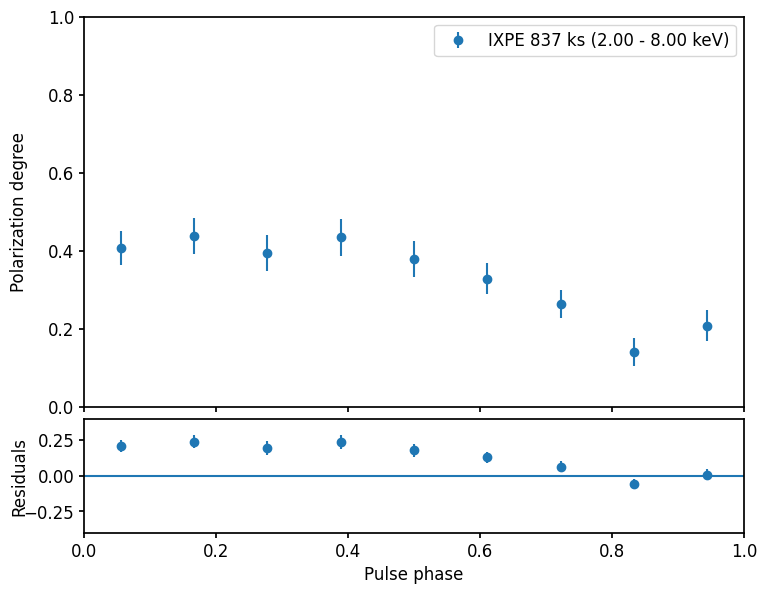

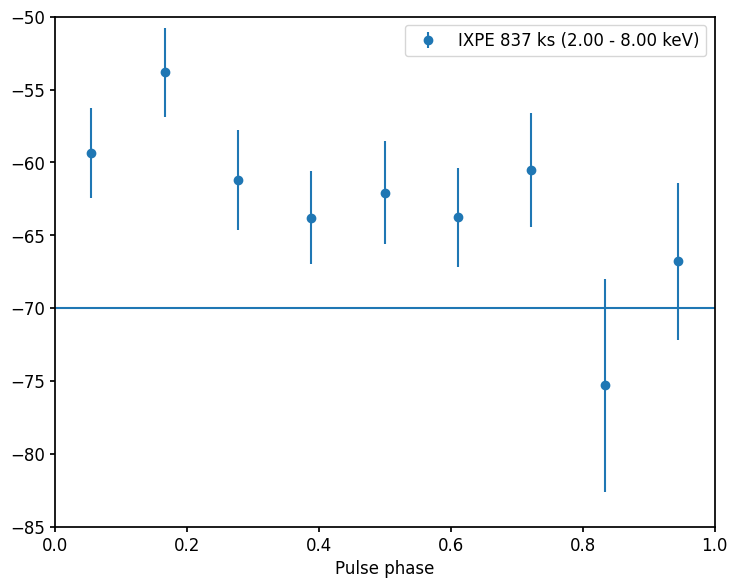

In [ ]:
def data_label(emin, emax):
    return 'IXPE %d ks (%.2f - %.2f keV)' % (pcube.ontime(), emin, emax)

def model_label():
    return 'Input model'

ax1, ax2 = pipeline.residual_figure('polarization degree')
for i, (min_, max_) in pairwise_enum(ENERGY_BINNING):
    pd = pol_deg[i,:]
    pderr = pol_deg_err[i,:]
    modpd = np.zeros_like(phase_bins) + 0.2
    plt.sca(ax1)
    plt.errorbar(phase_bins, pd, pderr, fmt='o', label=data_label(min_, max_))
    llc = last_line_color()
    plt.sca(ax2)
    plt.errorbar(phase_bins, pd - modpd, pderr,
                 fmt='o', color=llc)
    plt.sca(ax1)
    # plt.plot(phase, modpd, color=llc, label=model_label())
plt.sca(ax1)
setup_gca(ymin=0, ymax=1., legend=True, **fmtaxis.pp_pol_deg)
plt.sca(ax2)
plt.hlines(0., 0., 1.)
ymin, ymax = plt.ylim()
dy = max(abs(ymin), abs(ymax))
setup_gca(ymin=-dy, ymax=dy, xlabel=label.phase, ylabel='Residuals')

pipeline.figure('polarization angle')
for i, (min_, max_) in pairwise_enum(ENERGY_BINNING):
    plt.errorbar(phase_bins, pol_ang[i,:], pol_ang_err[i,:], fmt='o',
                 label=data_label(min_, max_))
    energy = np.mean(emean[i,:])
    plt.axhline(-70)
setup_gca(legend=True, xlabel=label.phase)
